<a href="https://colab.research.google.com/github/yongghongg/stock-screener/blob/main/stock_breakout_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install mplfinance
import requests
from bs4 import BeautifulSoup
import pandas as pd
import yfinance as yf
import numpy as np
import math
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

[*********************100%***********************]  1 of 1 completed


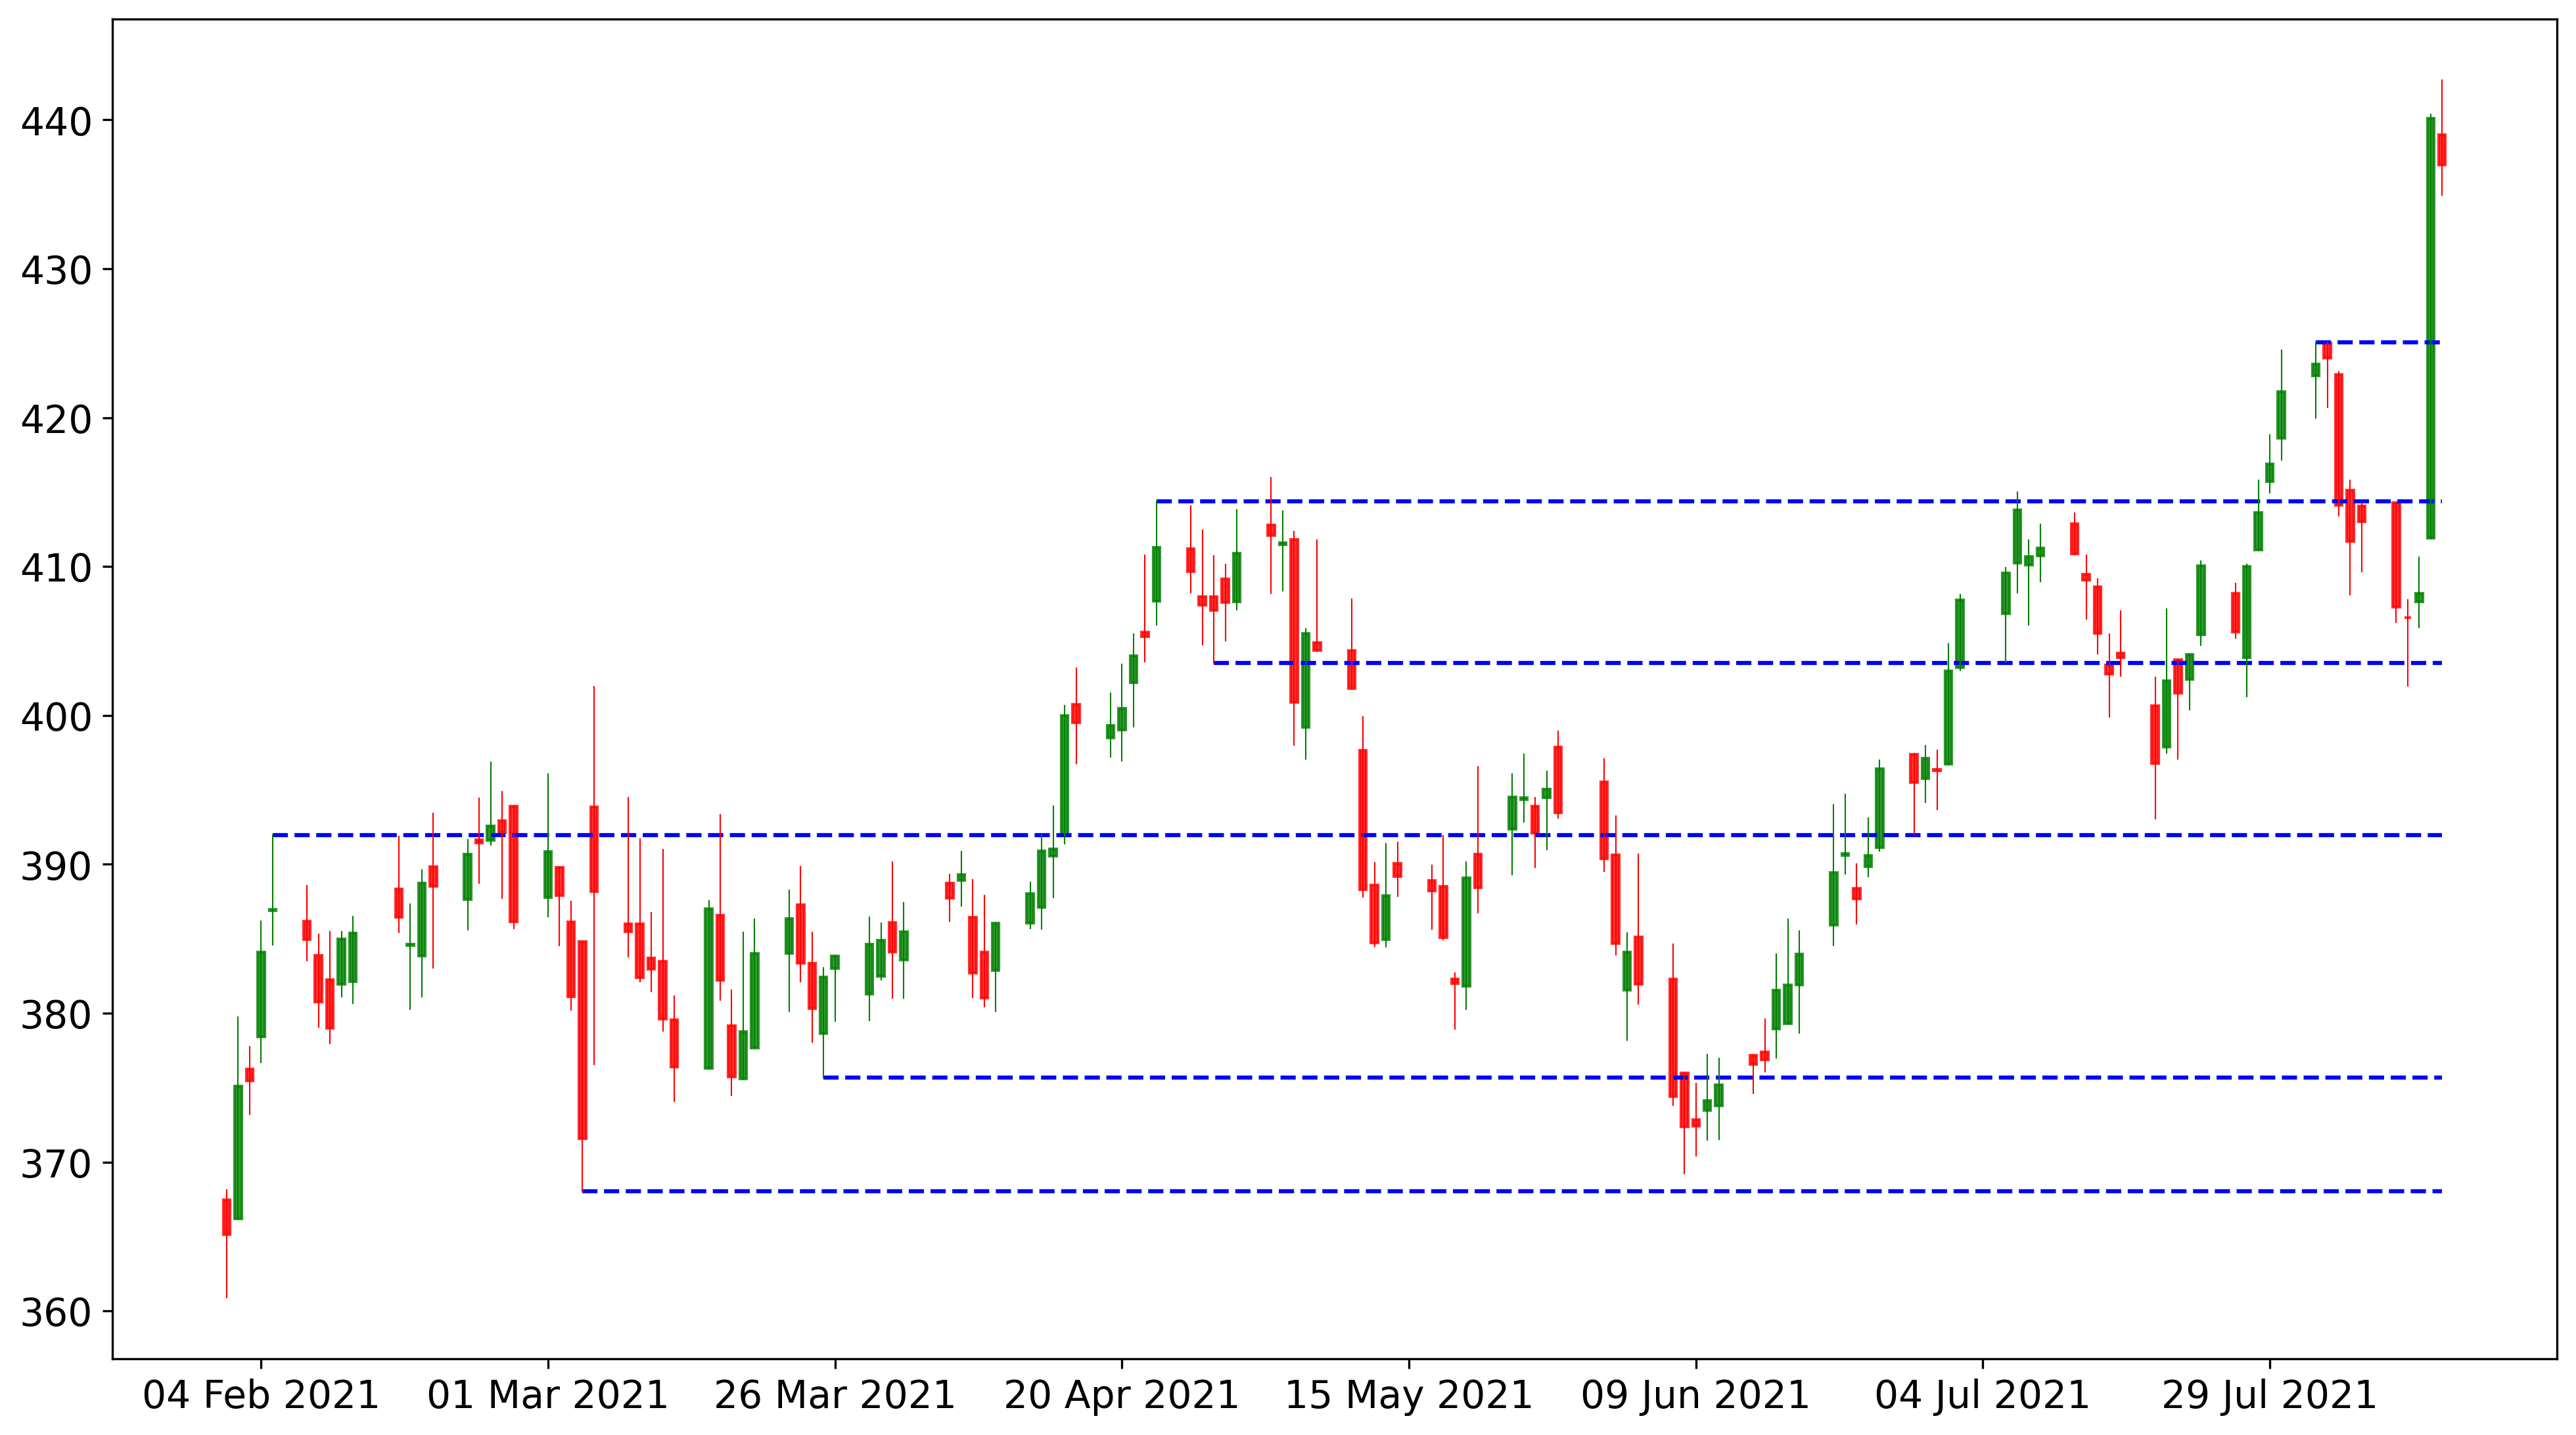

In [48]:
# method 1: fractal candlestick pattern

def get_stock_price(symbol):
  df = yf.download(symbol, start='2021-02-01', threads= False)
  df['Date'] = pd.to_datetime(df.index)
  df['Date'] = df['Date'].apply(mpl_dates.date2num)
  df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
  return df

def is_support(df,i):
  cond1 = df['Low'][i] < df['Low'][i-1] 
  cond2 = df['Low'][i] < df['Low'][i+1] 
  cond3 = df['Low'][i+1] < df['Low'][i+2] 
  cond4 = df['Low'][i-1] < df['Low'][i-2]
  return (cond1 and cond2 and cond3 and cond4)

def is_resistance(df,i):
  cond1 = df['High'][i] > df['High'][i-1] 
  cond2 = df['High'][i] > df['High'][i+1] 
  cond3 = df['High'][i+1] > df['High'][i+2] 
  cond4 = df['High'][i-1] > df['High'][i-2]
  return (cond1 and cond2 and cond3 and cond4)

def is_far_from_level(value, levels, df):
    ave =  np.mean(df['High'] - df['Low'])
    return np.sum([abs(value - level) < ave for _, level in levels]) == 0

def plot_all(levels, df):
    fig, ax = plt.subplots(figsize=(16, 9), dpi=300)
    candlestick_ohlc(ax,df.values,width=0.6, colorup='green', colordown='red', alpha=0.8)
    date_format = mpl_dates.DateFormatter('%d %b %Y')
    ax.xaxis.set_major_formatter(date_format)
    for level in levels:
        plt.hlines(level[1], xmin=df['Date'][level[0]], xmax=max(df['Date']), colors='blue', linestyle='--')
    fig.show()

stock_code = 'COO'
df = get_stock_price(stock_code)
levels = []
for i in range(2,len(df)-2):
  if is_support(df,i):
    l = df['Low'][i]
    if is_far_from_level(l, levels, df):
      levels.append((i,l))
  elif is_resistance(df,i):
    l = df['High'][i]
    if is_far_from_level(l, levels, df):
      levels.append((i,l))

plot_all(levels, df)

[*********************100%***********************]  1 of 1 completed


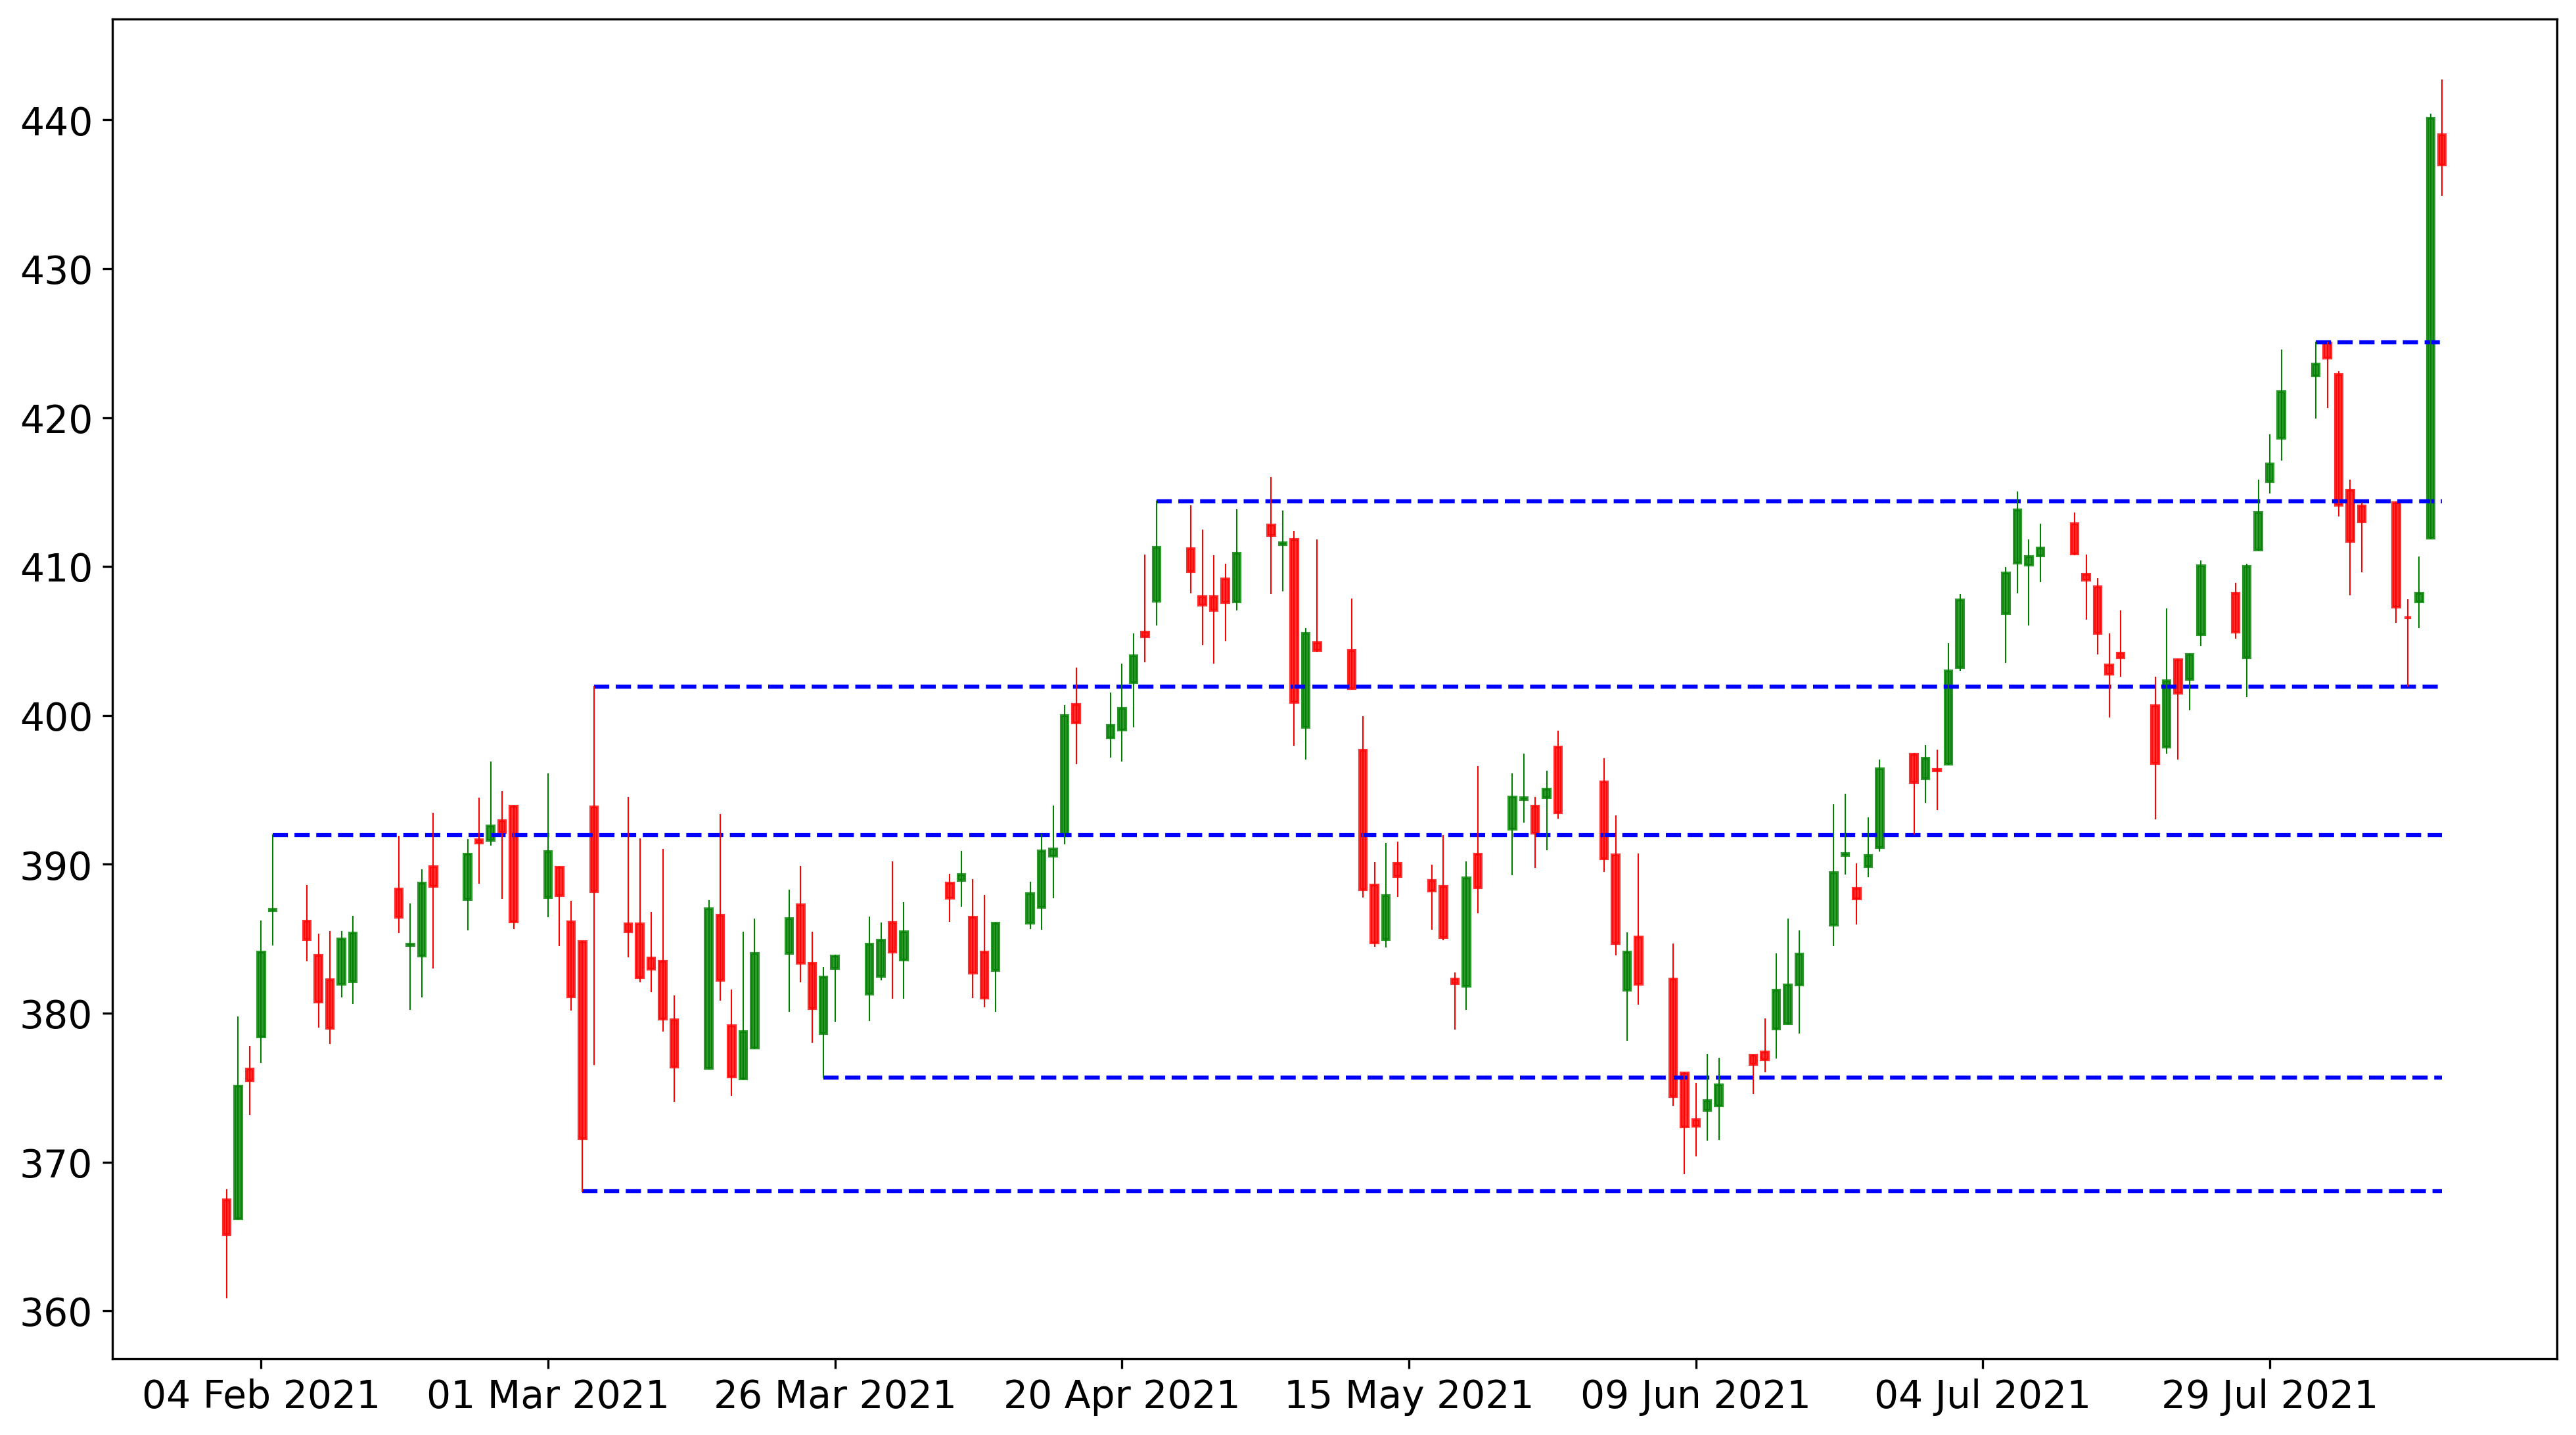

In [47]:
#method 2: window shifting method
symbol = 'COO'
df = get_stock_price(symbol)

pivots = []
max_list = []
min_list = []
for i in range(5, len(df)-5):
    high_range = df['High'][i-5:i+4]
    current_max = high_range.max()

    if current_max not in max_list:
        max_list = []
    max_list.append(current_max)
    if len(max_list) == 5 and is_far_from_level(current_max, pivots, df):
        pivots.append((high_range.idxmax(), current_max))
    
    low_range = df['Low'][i-5:i+5]
    current_min = low_range.min()
    if current_min not in min_list:
        min_list = []
    min_list.append(current_min)
    if len(min_list) == 5 and is_far_from_level(current_min, pivots, df):
        pivots.append((low_range.idxmin(), current_min))

plot_all(pivots, df)     

In [ ]:
# screening
def has_breakout(levels, previous, last):
  for _, level in levels:
    cond1 = (previous['Open'] < level) # to make sure previous candle is below the level
    cond2 = (last['Open'] > level) and (last['Low'] > level)
  return (cond1 and cond2)

def detect_level_method_1(df):
  levels = []
  for i in range(2,df.shape[0]-2):
    if is_support(df,i):
      l = df['Low'][i]
      if is_far_from_level(l, levels, df):
        levels.append((i,l))
    elif is_resistance(df,i):
      l = df['High'][i]
      if is_far_from_level(l, levels, df):
        levels.append((i,l))
  return levels

def detect_level_method_2(df):
  levels = []
  max_list = []
  min_list = []
  for i in range(5, len(df)-5):
      high_range = df['High'][i-5:i+4]
      current_max = high_range.max()

      if current_max not in max_list:
          max_list = []
      max_list.append(current_max)
      if len(max_list) == 5 and is_far_from_level(current_max, levels, df):
          levels.append((high_range.idxmax(), current_max))
      
      low_range = df['Low'][i-5:i+5]
      current_min = low_range.min()
      if current_min not in min_list:
          min_list = []
      min_list.append(current_min)
      if len(min_list) == 5 and is_far_from_level(current_min, levels, df):
          levels.append((low_range.idxmin(), current_min))
  return levels

# lists to store the screened results
screened_list_1 = [] 
screened_list_2 = []

# get the full stock list of S&P 500 
payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
stock_list = payload[0]['Symbol'].values.tolist()

for symbol in stock_list:
  try: 
    df = get_stock_price(symbol)
    
    levels_1 = detect_level_method_1(df)
    if (has_breakout(levels_1[-5:], df.iloc[-2], df.iloc[-1])):
      screened_list_1.append(symbol)

    levels_2 = detect_level_method_2(df)
    if (has_breakout(levels_2[-5:], df.iloc[-2], df.iloc[-1])):
      screened_list_2.append(symbol)

  except Exception as e:
    print(e)

In [41]:
screened_list_1

['ADBE', 'COO', 'COST', 'FE']

In [42]:
screened_list_2

['ACN', 'BDX', 'COO', 'DRI', 'IT', 'INTU', 'MDT', 'CRM']